In [43]:
import numpy as np
import matplotlib.pyplot as pyp
import sys
import os
import matplotlib
import datetime
import pandas as pd
import csv
import scipy.interpolate as interpolate
import glob
import numpy.fft as fft
from IPython import display
import pylab as pl
import time
%matplotlib inline
%matplotlib notebook

In [44]:
pyp.rcParams['font.size']=18

In [45]:
dirc_pre = './'
NFM_dirc = '%s/MountaintopNoiseFigure/'%(dirc_pre)
ant_dirc = "%s/Antennas/"%(dirc_pre)
predictDirc = '%s/PredictedSpectra'%(dirc_pre)
outDirc = "%s/comparisons/"%(dirc_pre)
measDirc = '/home/radio/data/beacon_september2018/'

In [46]:
def read_line(line, old=False, samprate=1e-9):
    if(old):
        stuff = line.split(',')
        channel = int(stuff[0])
        eventid = int(stuff[1])
        vals = []
        vals.append(float(stuff[2][2:]))
        for i in range(3, len(stuff)-1):
            vals.append(float(stuff[i]))
        vals.append(float(stuff[len(stuff)-1][:-4]))
        return pd.DataFrame({'channel': channel, 'eventid': eventid, 'volt': pd.Series(np.array(vals), index=np.arange(0., len(vals))*samprate)})
    else:
        stuff = line.split(',')
        #print("STUFF", stuff, "END STUFF")
        channel = int(stuff[0])
        eventid = int(stuff[1])
        timestamp = stuff[2]
        samprate = float(stuff[3])
        trigtime = float(stuff[4])
        #print("HEADER IN THIS LINE: ", channel, eventid, timestamp, samprate, trigtime, "END HEADER")
        vals = []
        vals.append(float(stuff[5][2:]))
        for i in range(6, len(stuff)-1):
            vals.append(float(stuff[i]))
        #print("VALS", vals, "END VALS")
        #print("END OF STUFF \\", stuff[len(stuff)-1], "\\")
        try:
            #print(4)
            vals.append(float(stuff[len(stuff)-1][:-4]))
        except:
            try:
                #print(3)
                vals.append(float(stuff[len(stuff)-1][:-3]))
            except:
                try:
                    #print(2)
                    vals.append(float(stuff[len(stuff)-1][:-2]))
                except:
                    try:
                        #print(1)
                        vals.append(float(stuff[len(stuff)-1][:-1]))
                    except:
                        #print(0)
                        print("", end=' ')
                        
        #print("made it", eventid)
        return pd.DataFrame({'channel': channel, 'eventid': eventid, 'samprate': samprate, 'trigtime': trigtime, 
                             'volt': pd.Series(np.array(vals), index=np.arange(0., len(vals))*samprate)})



In [47]:
#### NOTE: This only works for a 2-channel measurement where the channels used are 1 and 2!
def read_tekscope_file(fname):
    events = {}
    with open(fname, 'r') as fi:
        for line in fi:
            #print(line)
            event = read_line(line)
            #print(event.channel)
            if(event.channel.iloc[0] == 1):
                evs = []
                #evs.append(event)  
            #if(event.channel.iloc[0] == 2):
            evs.append(event)
            events[event.eventid.iloc[0]] = evs
                #print(event.eventid.iloc[0], events[event.eventid.iloc[0]])
    #print(events)
    #print( pd.DataFrame(events) )
    return pd.DataFrame(events)

In [48]:
channel_names = {1: 'After Stage2', 2: 'After Tunnel Diode', 3: 'Chan3', 4: 'Chan4'}
def draw_wave(events, eventid):
    event = events[eventid]

    for ich in range(0, 2):
        channel = event[ich]
        #print("Drawing channel ", channel.channel.iloc[0], " event ", channel.eventid.iloc[0], " with ", len(
        #    channel.volt), " points ")
        pyp.figure(1, figsize=(12,4))
        ax = pyp.subplot(1, 2, ich+1)
        pyp.plot(channel.volt.index*1e9, channel.volt)
        ax.set_title(channel_names[ich+1])
        fv = fft.rfft(channel.volt.values)
        freq = fft.rfftfreq(len(channel.volt.values),
                            d=channel.samprate.iloc[0])
        
def draw_channel(events, eventid, ich):
    event = events[eventid]

    channel = event[ich]
    #print("Drawing channel ", channel.channel.iloc[0], " event ", channel.eventid.iloc[0], " with ", len(
    #    channel.volt), " points ")
    pyp.figure(1, figsize=(16,4))
    ax = pyp.subplot(1, 2, 1)
    pyp.plot(channel.volt.index*1e9, channel.volt)
    ax.set_title("Waveform")
    pyp.xlabel("Time (ns)")
    pyp.ylabel("Voltage (mV)")
    
    ax = pyp.subplot(1,2,2)
    fv = fft.rfft(channel.volt.values)
    freq = fft.rfftfreq(len(channel.volt.values),
                        d=channel.samprate.iloc[0])
    pyp.semilogy(freq/1e6, abs(fv)**2)
    ax.set_title("Power Spectrum")
    pyp.xlabel("Frequency (MHz)")
    pyp.ylabel("Power (mV$^2$)")
    
def draw_channel_ax(ax,events, eventid, ich):
    event = events[eventid]

    channel = event[ich]
    #print("Drawing channel ", channel.channel.iloc[0], " event ", channel.eventid.iloc[0], " with ", len(
    #    channel.volt), " points ")
    #pyp.figure(1, figsize=(16,4))
    #ax = pyp.subplot(1, 2, 1)
    ax[0].plot(channel.volt.index*1e9, channel.volt)
    ax[0].set_title("Waveform")
    ax[0].set_xlabel("Time (ns)")
    ax[0].set_ylabel("Voltage (mV)")
    
    #ax = pyp.subplot(1,2,2)
    fv = fft.rfft(channel.volt.values)
    freq = fft.rfftfreq(len(channel.volt.values),
                        d=channel.samprate.iloc[0])
    ax[1].semilogy(freq/1e6, abs(fv)**2)
    ax[1].set_title("Power Spectrum")
    ax[1].set_xlabel("Frequency (MHz)")
    ax[1].set_ylabel("Power (mV$^2$)")

In [49]:
def zoom_wave(events,eventid, ich, window_ns):
    event = events[eventid]
    channel = event[ich]
    mini = min(channel.volt)
    maxi = max(channel.volt)
    
    zoom_to = maxi
    if( abs(mini) > maxi):
        zoom_to = mini
        
    ind = np.where(channel.volt == zoom_to)[0][0]
    min_time_ns = channel.index[ind]*1e9 - window_ns*0.25
    max_time_ns = channel.index[ind]*1e9 + window_ns*0.75
    
    pyp.xlim(min_time_ns, max_time_ns)
    return min_time_ns, max_time_ns, zoom_to

def zoom_wave_ax(ax,events,eventid, ich, window_ns):
    event = events[eventid]
    channel = event[ich]
    mini = min(channel.volt)
    maxi = max(channel.volt)
    
    zoom_to = maxi
    if( abs(mini) > maxi):
        zoom_to = mini
        
    ind = np.where(channel.volt == zoom_to)[0][0]
    min_time_ns = channel.index[ind]*1e9 - window_ns*0.25
    max_time_ns = channel.index[ind]*1e9 + window_ns*0.75
    
    ax[0].set_xlim(min_time_ns, max_time_ns)
    return min_time_ns, max_time_ns, zoom_to

In [50]:
def getData(run, date, instr):
    
    measSpecHead = []
    measSpecRunHead = []
    measSpectra = []
    measRatesHead = []
    measRates = []
    measWaves = []
     
    for ins in instr:
        if ins == 'specanalyzer':
            globName = "%s/%d/%s_run%d_*.hdf5"%(measDirc,date,ins,run)
            print(globName)
            measFi = glob.glob(globName)[-1]
            measSpecHead = pd.read_hdf(measFi, key='header')
            measSpecRunHead = pd.read_hdf(measFi, key='run_header')
            measSpectra = pd.read_hdf(measFi, key='spectra')
            print("Spectrum Analyzer File Name", measFi)
        elif ins == 'photonCounter':
            globName = "%s/%d/%s_run%d_*.hdf5"%(measDirc,date,ins,run)
            measFi = glob.glob(globName)[-1]
            print("Photon Counter File Name", measFi)
            measRatesHead = pd.read_hdf(measFi, key='header')
            measRates = pd.read_hdf(measFi, key='rates')
        elif ins == 'tekScope':
            globName = "%s/%s/%s/%s_run%d_*.csv"%(measDirc,date,date,ins,run)
            measFi = glob.glob(globName)[-1]
            print("Scope File Name ", measFi)
            measWaves = read_tekscope_file(measFi)

    return measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves

In [51]:
def plotThresholdScan(headSet, ratesSet, label=''):
    pyp.semilogy(ratesSet.thresholdmV*10**3, ratesSet.rates, linewidth=1,label=label)
    pyp.xlabel("Threshold Voltage (mV)")
    pyp.ylabel("Rates (Hz)")
    pyp.xlim(0,300)

In [52]:
def plotRatesTime(headSet, ratesSet, label=''):
    pyp.semilogy(ratesSet.timestamp, ratesSet.rates, linewidth=1, label='')
    pyp.xlabel("Time (s)")
    pyp.ylabel("Rates (Hz)")

In [53]:
def plotSpectrum(headSet, specSet, key, label=''):
        head = headSet[key]
        spec = specSet[key]
        
        pyp.figure(1,figsize=(8, 16))
        pyp.subplot(2, 1, 1)
        pyp.title(head['DATE'])
        pyp.plot(spec.freq_hz/1e6, spec.power_dBm, label=label)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Power (dBm)")
        pyp.subplot(2, 1, 2)
        pyp.plot(spec.freq_hz/1e6, spec.power_dBm - 10. *
                 np.log10(head['rbw_hz']/1e6), label=label)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Power Spectral Density (dBm/MHz)")
        #pyp.show()

def plotSpectrogram(headSet, specSet, label=''):
        pyp.figure(2,figsize=(8, 16))
        pyp.subplot(2, 1, 1)
        pyp.title(label)
        timestamps = headSet.keys()

        # Get all the time stamps
        datestrf = '%Y-%m-%d-%W-%H-%M-%S'
        datetimestamps = [datetime.datetime.strptime(
            ts, datestrf) for ts in timestamps]

        starttime = datetimestamps[0]
        tdelta = np.zeros(len(datetimestamps))
        for i, ts in enumerate(datetimestamps):
            tdelta[i] = (ts - starttime).total_seconds()

        # Setup the spectrogram array
        spectrogram = np.zeros((len(datetimestamps), len(
            specSet[timestamps[0]]['power_dBm'])))
        for i, dt in enumerate(tdelta):
            timestamp = timestamps[i]
            spec = specSet[timestamp]['power_dBm']
            spectrogram[i, :] = spec

        # make a mesh for plotting
        freqmesh, timemesh = np.meshgrid(
            specSet[timestamp]['freq_hz']/1e6, tdelta)
        # plot!
        pyp.pcolormesh(freqmesh, timemesh, spectrogram,vmin=-80,vmax=-20)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Time(s)")
        pyp.title(starttime.strftime(format=datestrf))
        cbar = pyp.colorbar()
        cbar.set_label("Power (dBm)")

        # plot!
        pyp.subplot(2, 1, 2)
        pyp.pcolormesh(freqmesh, timemesh, spectrogram -
                       10.*np.log10(headSet[timestamp]['rbw_hz']/1e6),
                      vmin=-80,vmax=-20)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Time(s)")
        pyp.title(starttime.strftime(format=datestrf))
        cbar = pyp.colorbar()
        cbar.set_label("Power (dBm/MHz)")

## Notes from Summit site survey at WMRS:

Overall, the site survey was difficult logisitically, because the winds were very strong (average 55 mph). We took a minimal set of waveforms, spectra, and traces in VHF using the bicones. We started out with a terminated run, moved to Hpol and then finished with Vpol. During the Hpol run (6) the antenna was blown off the tripod and we had to position the antenna lower on the tripod and have someone hold it for the rest of the data taking.

After the rates runs (at about 2PM), we tried to set up for interferometry runs, but damaged the box 1 set of amplifiers. We need to prepare in the future for this by simplifying the system and having more spare amplifiers.
    

We took a total of 11 runs during the site survey at Summit Station. All day we used the VHF Box 1 set (Stage 1 and Stage 2) and the configuration written down in the notebook. The only difference from the runs at WMRS Observatory of note is that the cable from the Stage 1 + filters to the antenna was a 10 ft LMR240 cable and we used a single 50ft length of LMR 400 between Stage 1 and Stage 2. 

We started out with terminator runs (Runs 1-3), taking spectra and waveforms on the scope (1 and 2) and a threshold scan (3). Next we did a series of Hpol runs, starting with spectra and waveforms, taking a threshold scan, and then running at the threshold (63 mV) that corresponded to 1 Hz rate with the terminator. We finished with a threshold scan in Vpol and then a rates, spectra, and waveforms run at 63 mV again.

### Terminator Runs:

#### 1: Terminator + NLP-90 + NLP-100 before stage 1 and NLP-90 after stage 2. Run with waveforms and spectra with terminator. SA in trace mode

In [113]:
run = 1
fignum = 1
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'specanalyzer', 'tekScope'])

/home/radio/data/beacon_september2018//20180915/specanalyzer_run1_*.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_september2018//20180915/specanalyzer_run1_2018-09-15_11-54-02.hdf5
Scope File Name  /home/radio/data/beacon_september2018//20180915/20180915/tekScope_run1_20180915_11-54-04-801845.csv


In [114]:
for key in measSpecRunHead.keys():
    print(key, ":", measSpecRunHead[key].values[0])

run : 1
timestamp : 1537037642.7897751
filename : specanalyzer_run1_2018-09-15_11-54-02.hdf5
freqband : VHF
pol : None
weather : cold
daynight : day
comments : forgot to turn on analyzer first time. taKIng terminatrore run data. set up on eastern side ofd summit overlooking dyer valley abvoutr 100 ft below summit on the road
boxno : 1
before_stage1_attenfilter : terminator NLP-90 NLP-100
after_stage2_attenfilter : NLP-90


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


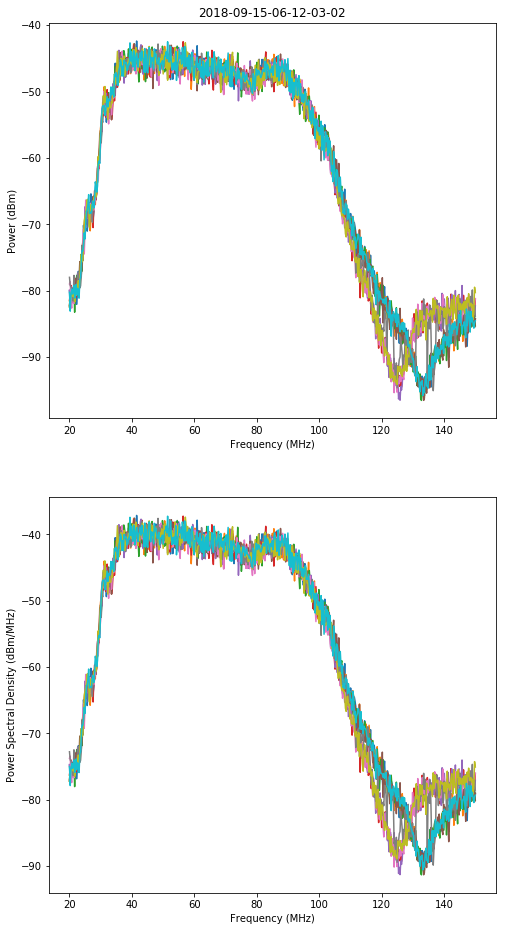

In [115]:
for j in range(len(measSpecHead.keys())):
    plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j])

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


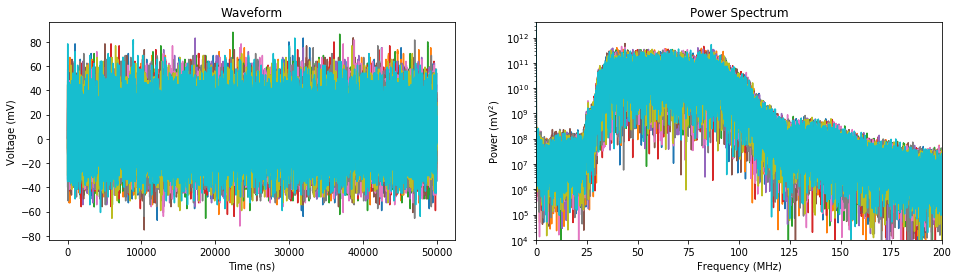

In [116]:
therm_ind = range(10)
#print(measWaves)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)
        
pyp.subplot(1,2,2)
pyp.xlim(0,200)
pyp.ylim(1e4,4e12)


fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

#### 2: Second terminated run with waveforms and spectra with SA in averaging mode, rather than trace mode.

In [117]:
run = 2
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'specanalyzer', 'tekScope'])

/home/radio/data/beacon_september2018//20180915/specanalyzer_run2_*.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_september2018//20180915/specanalyzer_run2_2018-09-15_11-59-38.hdf5
Scope File Name  /home/radio/data/beacon_september2018//20180915/20180915/tekScope_run2_20180915_11-59-41-676451.csv


In [118]:
for key in measSpecRunHead.keys():
    print(key, ":", measSpecRunHead[key].values[0])

run : 2
timestamp : 1537037978.3107886
filename : specanalyzer_run2_2018-09-15_11-59-38.hdf5
freqband : VHF
pol : None
weather : cold windy
daynight : day
comments : same as beforew SA in average mode increase3d vertical scale in scope
boxno : 1
before_stage1_attenfilter : terminatror, NLP-90 NLP-100
after_stage2_attenfilter : NLP-90


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


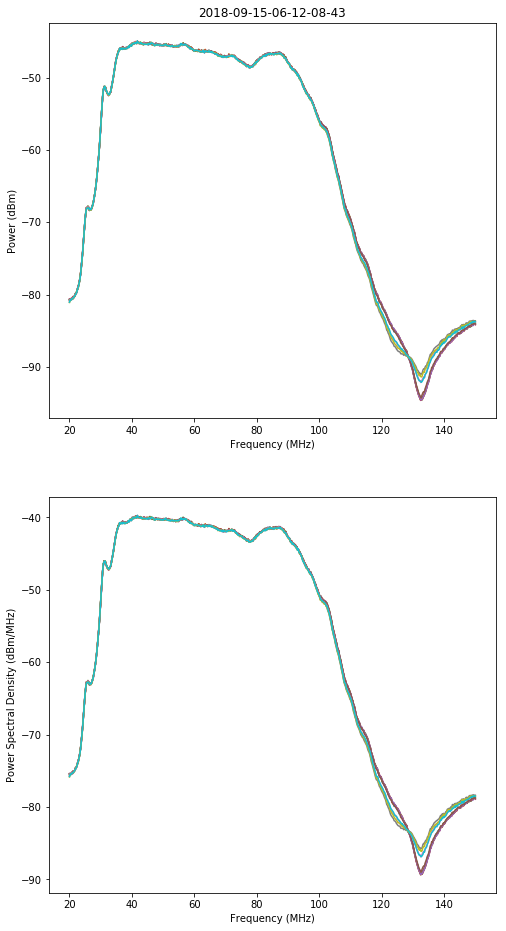

In [119]:
for j in range(len(measSpecHead.keys())):
    plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j])

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


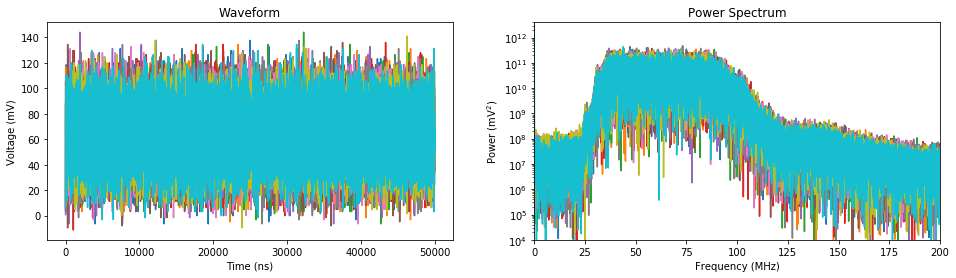

In [120]:
therm_ind = range(10)
#print(measWaves)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)
        
pyp.subplot(1,2,2)
pyp.xlim(0,200)
pyp.ylim(1e4,4e12)

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

#### 3: Threshold scan with terminator

In [121]:
run = 3
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    3, 20180915, [ 'photonCounter'])

Photon Counter File Name /home/radio/data/beacon_september2018//20180915/photonCounter_run3_2018-09-15_12-04-35.hdf5


In [122]:
for key in measRatesHead.keys():
    print(key, ":", measRatesHead[key].values[0])

run : 3
timestamp : 1537038275.8877854
filename : photonCounter_run3_2018-09-15_12-04-35.hdf5
freqband : VHF
pol : None
weather : cold
daynight : day
comments : 
discAMode : 0
fixedDiscThresholdmV : -1
countPeriodSeconds : 1.0
NPeriods : 1
countMode : 0
counterAInput : 1
counterTInput : 0


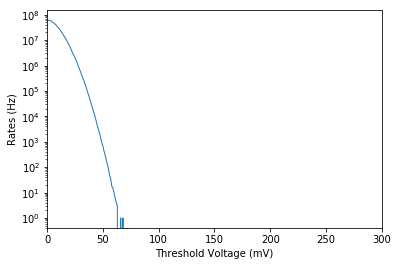

In [123]:
plotThresholdScan(measRatesHead, measRates)
#pyp.ylim(0.1,10)
#pyp.xlim(50,75)


fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

In [124]:
termRatesHead = measRatesHead
termRates = measRates

### Hpol Runs:

#### 4 : Waveforms and spectra in Hpol. SA in normal mode

NOTE: THE HEADER FOR THIS RUN SAYS THAT THERE WAS A TERMINATOR, BUT THERE WAS NOT. We connected the filters on the input to stage 1 to the Hpol antenna  via a 10 ft LMR240 cable. SA 


In [125]:
run = 4
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'specanalyzer', 'tekScope'])

/home/radio/data/beacon_september2018//20180915/specanalyzer_run4_*.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_september2018//20180915/specanalyzer_run4_2018-09-15_12-23-57.hdf5
Scope File Name  /home/radio/data/beacon_september2018//20180915/20180915/tekScope_run4_20180915_12-24-01-884863.csv


In [126]:
for key in measSpecRunHead.keys():
    print(key, ":", measSpecRunHead[key].values[0])

run : 4
timestamp : 1537039437.2425332
filename : specanalyzer_run4_2018-09-15_12-23-57.hdf5
freqband : VHF
pol : H
weather : cold. very cold
daynight : day
comments : sa in normal trace mode 42MH line is coming and going
boxno : 1
before_stage1_attenfilter : Terminator, NLP-90, NLP-100
after_stage2_attenfilter : NLP-90


In [68]:
for key in measSpecHead.keys():
        print(key, ":", measSpecHead[key])

2018-09-15-06-12-31-09 : ACPR_ADJC_CH_BW                        10.350000 MHZ
ACPR_CHANNEL_SPACING                   10.350000 MHZ
ACPR_LOWER_CH_LINE_MARKER_INFO              0.000000
ACPR_LOWER_CH_PWR                       10.000000 DB
ACPR_MAIN_CH_BW                        10.350000 MHZ
ACPR_MAIN_CH_LINE_MARKER_INFO               0.000000
ACPR_MAIN_CH_PWR                       10.000000 DBM
ACPR_UPPER_CH_LINE_MARKER_INFO              0.000000
ACPR_UPPER_CH_PWR                       10.000000 DB
ACTIVE_MEASUREMENT                          0.000000
AM_FM_DEMOD_FREQUENCY                  10.350000 MHZ
AM_FM_DEMOD_TIME                          3.000000 S
AM_FM_DEMOD_TYPE                            1.000000
AM_FM_DEMOD_VOL                             0.000000
AM_FM_LINE_MARKER                           0.000000
ANTENNA                                     0.000000
APP_MODE                                            
APP_NAME                                         SPA
APP_VER              

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


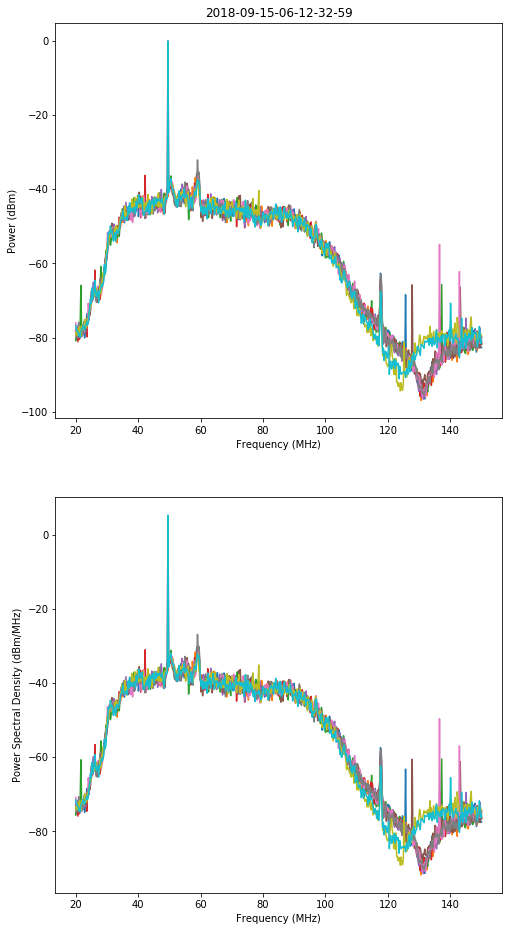

In [127]:
for j in range(len(measSpecHead.keys())):
    plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j])

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

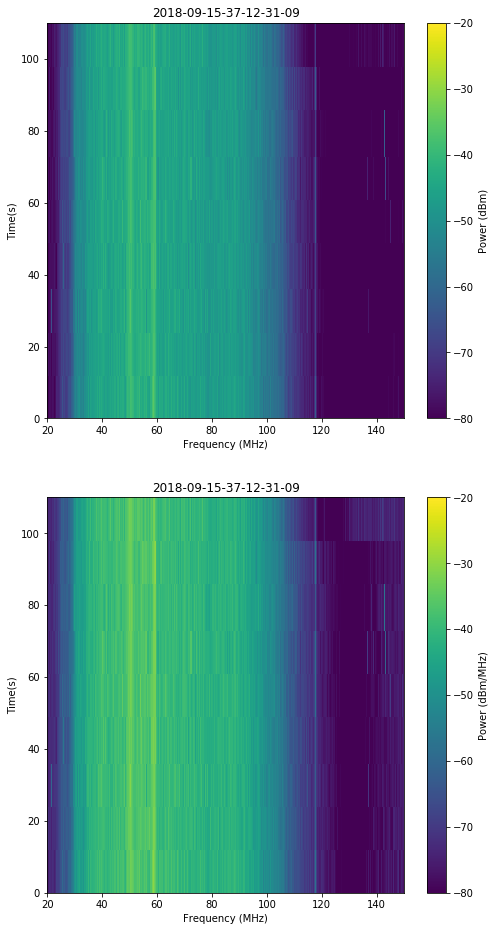

In [128]:
plotSpectrogram(measSpecHead,measSpectra)


fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


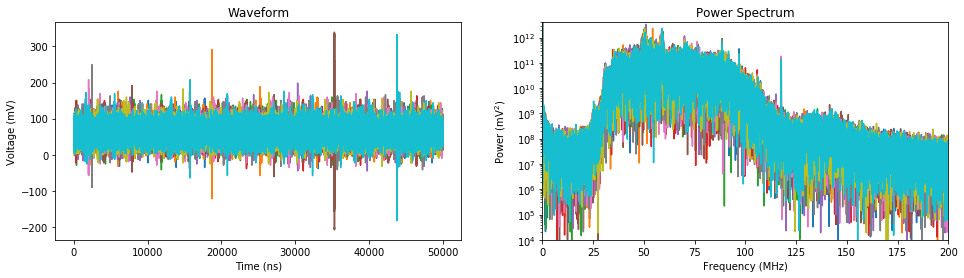

In [129]:
therm_ind = range(10)
#print(measWaves)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)
        
pyp.subplot(1,2,2)
pyp.xlim(0,200)
pyp.ylim(1e4,4e12)


fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

#### 5 : Waveforms and spectra in Hpol. SA in avereage mode, 100 averages

In [130]:
run=5
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'specanalyzer', 'tekScope'])

/home/radio/data/beacon_september2018//20180915/specanalyzer_run5_*.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_september2018//20180915/specanalyzer_run5_2018-09-15_12-29-08.hdf5
Scope File Name  /home/radio/data/beacon_september2018//20180915/20180915/tekScope_run5_20180915_12-29-17-944852.csv


In [131]:
for key in measSpecRunHead.keys():
    print(key, ":", measSpecRunHead[key].values[0])

run : 5
timestamp : 1537039748.5750923
filename : specanalyzer_run5_2018-09-15_12-29-08.hdf5
freqband : VHF
pol : H
weather : cold
daynight : day
comments : sa in average mode scope trigger level 0mv
boxno : 1
before_stage1_attenfilter : NLP-90 NLP-100
after_stage2_attenfilter : NLP-90


In [132]:
for key in measSpecHead.keys():
        print(key, ":", measSpecHead[key])

2018-09-15-06-12-36-25 : ACPR_ADJC_CH_BW                         10.350000 MHZ
ACPR_CHANNEL_SPACING                    10.350000 MHZ
ACPR_LOWER_CH_LINE_MARKER_INFO               0.000000
ACPR_LOWER_CH_PWR                        10.000000 DB
ACPR_MAIN_CH_BW                         10.350000 MHZ
ACPR_MAIN_CH_LINE_MARKER_INFO                0.000000
ACPR_MAIN_CH_PWR                        10.000000 DBM
ACPR_UPPER_CH_LINE_MARKER_INFO               0.000000
ACPR_UPPER_CH_PWR                        10.000000 DB
ACTIVE_MEASUREMENT                           0.000000
AM_FM_DEMOD_FREQUENCY                   10.350000 MHZ
AM_FM_DEMOD_TIME                           3.000000 S
AM_FM_DEMOD_TYPE                             1.000000
AM_FM_DEMOD_VOL                              0.000000
AM_FM_LINE_MARKER                            0.000000
ANTENNA                                      0.000000
APP_MODE                                             
APP_NAME                                          SPA
APP

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


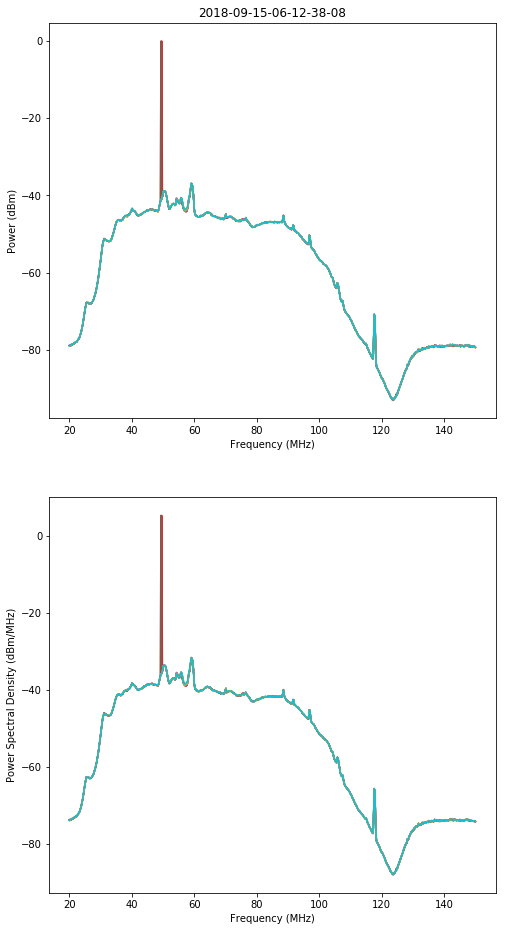

In [133]:
for j in range(len(measSpecHead.keys())):
    plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j])

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

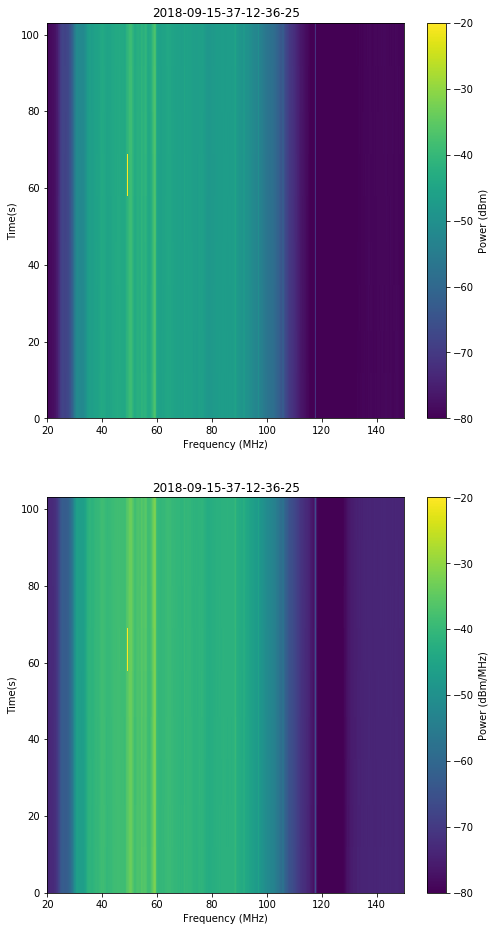

In [134]:
plotSpectrogram(measSpecHead,measSpectra)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


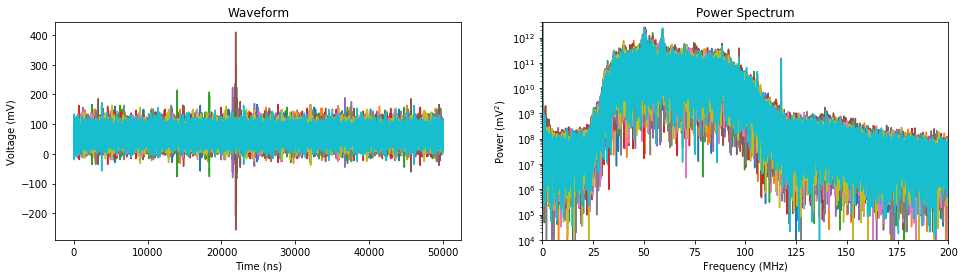

In [135]:
therm_ind = range(10)
#print(measWaves)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)
        
pyp.subplot(1,2,2)
pyp.xlim(0,200)
pyp.ylim(1e4,4e12)

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

#### 6 : Hpol threshold scan. Canceled run, because the antenna was knocked down by the wind

#### 7: Hpol threshold scan. Andres RW holding antenna in lower position. Hereafter someone (Andres RW or Andres R was holding the antenna.)

In [136]:
run = 7 
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'photonCounter'])

Photon Counter File Name /home/radio/data/beacon_september2018//20180915/photonCounter_run7_2018-09-15_12-43-03.hdf5


In [137]:
for key in measRatesHead.keys():
    print(key, ":", measRatesHead[key].values[0])

run : 7
timestamp : 1537040583.1187947
filename : photonCounter_run7_2018-09-15_12-43-03.hdf5
freqband : VHF
pol : H
weather : WINDY
daynight : day
comments : andres rw holding antena. wind knocked it down lost clamp. andres will hold antena fdrom now on
discAMode : 0
fixedDiscThresholdmV : -1
countPeriodSeconds : 1.0
NPeriods : 1
countMode : 0
counterAInput : 1
counterTInput : 0


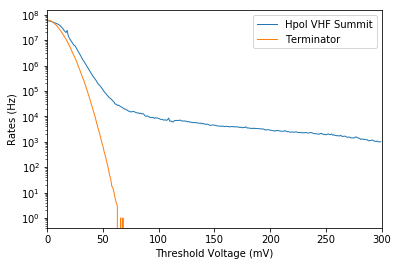

In [139]:
plotThresholdScan(measRatesHead, measRates, label='Hpol VHF Summit')
plotThresholdScan(termRatesHead, termRates, label='Terminator')
#pyp.ylim(0.1,10)
#pyp.xlim(50,75)
pyp.legend()
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

#### 8 : Rates run in Hpol with rates from photon counter, spectra from SA, and waveforms from scope.



Trigger level on scope was 0 mV (should be checked in the data header), so unbiased. Chose threshold for photon counter of 63 mV that corresponds to the threhsold at which the terminator gave 1 Hz rates.

In [140]:
run =8 
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'tekScope', 'specanalyzer','photonCounter'])

Scope File Name  /home/radio/data/beacon_september2018//20180915/20180915/tekScope_run8_20180915_12-52-26-733912.csv
/home/radio/data/beacon_september2018//20180915/specanalyzer_run8_*.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_september2018//20180915/specanalyzer_run8_2018-09-15_12-52-22.hdf5
Photon Counter File Name /home/radio/data/beacon_september2018//20180915/photonCounter_run8_2018-09-15_12-52-18.hdf5


In [141]:
for key in measRatesHead.keys():
    print(key, ":", measRatesHead[key].values[0])

run : 8
timestamp : 1537041138.512412
filename : photonCounter_run8_2018-09-15_12-52-18.hdf5
freqband : VHF
pol : H
weather : Cold and windy
daynight : Day
comments : Choosing 63 mV,because that's where the terminator reaches a rate of 1 Hz
boxno : 1
before_stage1_attenfilter : NLP-90, NLP-100
after_stage2_attenfilter : NLP-90
fixedDiscThresholdmV : 63.0
discAMode : 0
runTimeMinutes : 10.0
countPeriodSeconds : 1.0
NPeriods : 600
countMode : 0
counterAInput : 1
counterTInput : 0


In [142]:
for key in measSpecRunHead.keys():
    print(key, ":", measSpecRunHead[key].values[0])

run : 8
timestamp : 1537041142.7978628
filename : specanalyzer_run8_2018-09-15_12-52-22.hdf5
freqband : VHF
pol : H
weather : Cold and windy
daynight : Day
comments : Choosing 63 mV,because that's where the terminator reaches a rate of 1 Hz
boxno : 1
before_stage1_attenfilter : NLP-90, NLP-100
after_stage2_attenfilter : NLP-90


In [143]:
for key in measSpecHead.keys():
        print(key, ":", measSpecHead[key])

2018-09-15-06-12-59-34 : ACPR_ADJC_CH_BW                        10.350000 MHZ
ACPR_CHANNEL_SPACING                   10.350000 MHZ
ACPR_LOWER_CH_LINE_MARKER_INFO              0.000000
ACPR_LOWER_CH_PWR                       10.000000 DB
ACPR_MAIN_CH_BW                        10.350000 MHZ
ACPR_MAIN_CH_LINE_MARKER_INFO               0.000000
ACPR_MAIN_CH_PWR                       10.000000 DBM
ACPR_UPPER_CH_LINE_MARKER_INFO              0.000000
ACPR_UPPER_CH_PWR                       10.000000 DB
ACTIVE_MEASUREMENT                          0.000000
AM_FM_DEMOD_FREQUENCY                  10.350000 MHZ
AM_FM_DEMOD_TIME                          3.000000 S
AM_FM_DEMOD_TYPE                            1.000000
AM_FM_DEMOD_VOL                             0.000000
AM_FM_LINE_MARKER                           0.000000
ANTENNA                                     0.000000
APP_MODE                                            
APP_NAME                                         SPA
APP_VER              

<IPython.core.display.Javascript object>


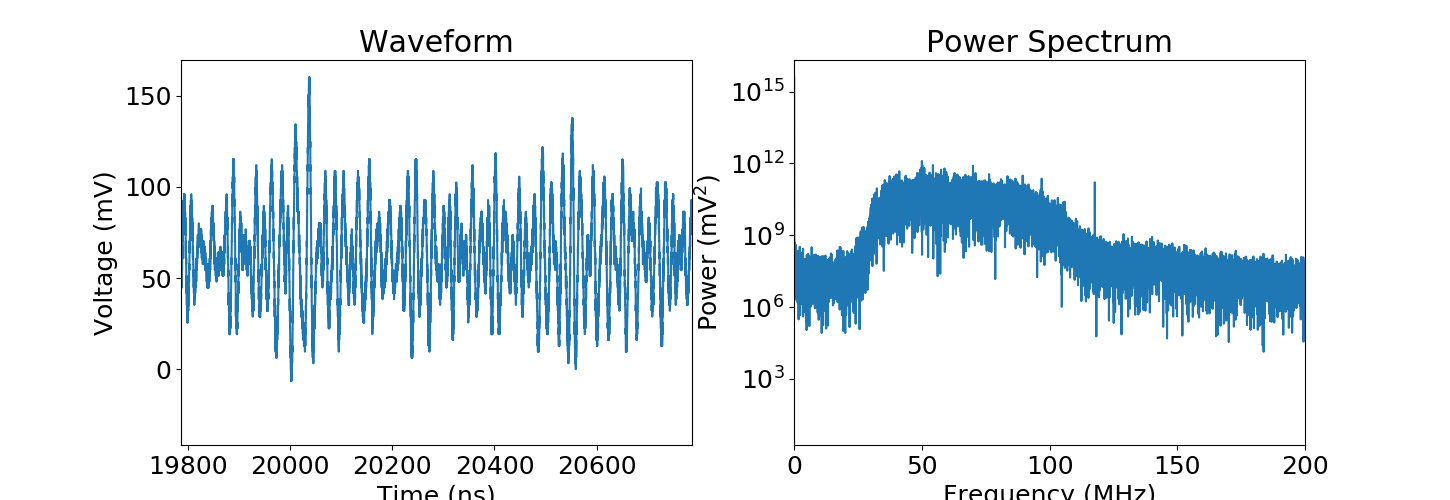

In [144]:
%matplotlib notebook
fig,ax = pyp.subplots(1,2,figsize=(14.5,5))
for eid in measWaves.keys():
    if( eid > 1):
        ax[0].clear()
        ax[1].clear()
    chan = 0
    draw_channel_ax(ax,measWaves,eid,chan)
    #pyp.subplot(1,2,1)
    zoom_wave_ax(ax,measWaves,eid,chan, 1000)
    #ax.subplot(1,2,2)
    ax[1].set_xlim(0,200)
    #yp.show()
    fig.canvas.draw()
    #
    #display.display(pl.gcf())
    #display.clear_output(wait=True)
    time.sleep(1)
    

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


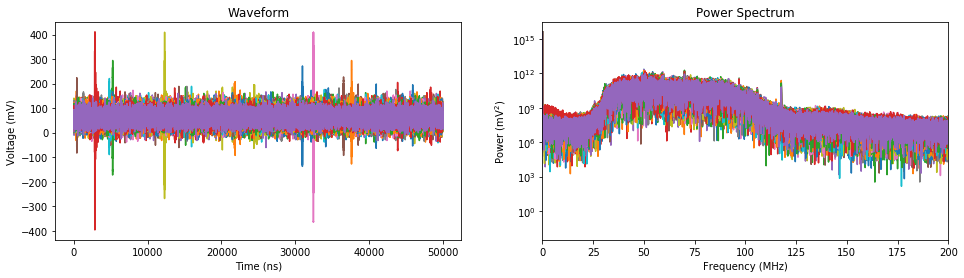

In [145]:
%matplotlib inline
therm_ind = range(45)
#print(measWaves)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)
pyp.subplot(1,2,2)
pyp.xlim(0,200)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


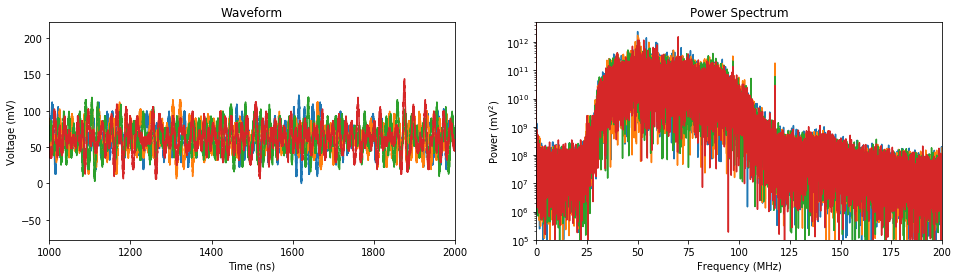

In [146]:
# change the indices to select different waveforms
wave_ind = [0,12,73,80]
for eid in measWaves.keys()[wave_ind]:
        draw_channel(measWaves, eid,0)
pyp.subplot(1,2,1)
pyp.xlim(1000,2000)
pyp.subplot(1,2,2)
pyp.xlim(0,200)
pyp.ylim(1e5,5e12)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

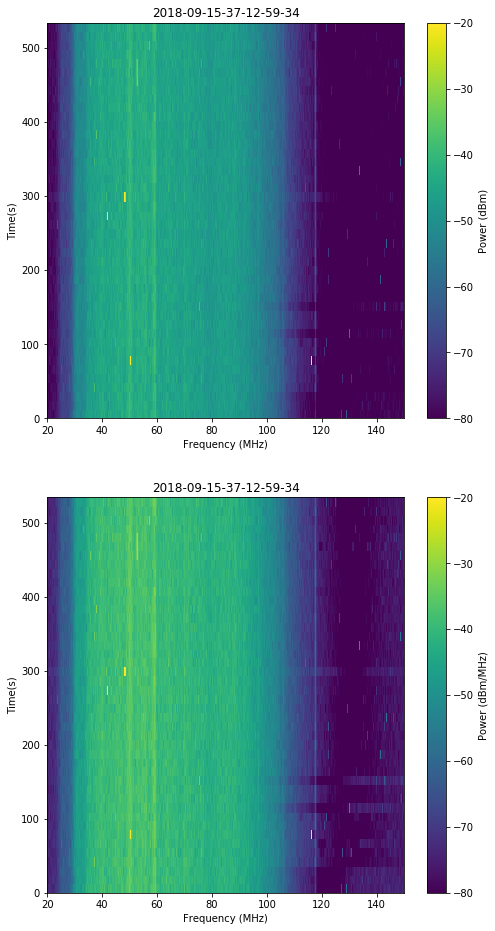

In [147]:
plotSpectrogram(measSpecHead, measSpectra)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

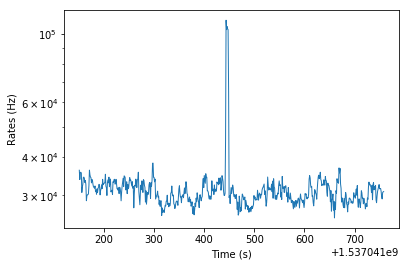

In [148]:
plotRatesTime(measRatesHead,measRates)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

### Vpol Runs:

#### 9: Threshold scan in Vpol. Canceled run, because we forgot to switch the antenna from Hpol to Vpol 

#### 10: Threshold scan in Vpol. **After** rotating antenna into Vpol

In [149]:
run = 10
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'photonCounter'])

Photon Counter File Name /home/radio/data/beacon_september2018//20180915/photonCounter_run10_2018-09-15_13-06-40.hdf5


In [150]:
for key in measRatesHead.keys():
    print(key, ":", measRatesHead[key].values[0])

run : 10
timestamp : 1537042000.9803853
filename : photonCounter_run10_2018-09-15_13-06-40.hdf5
freqband : VHF
pol : V
weather : Cold and windy
daynight : Day
comments : Plane flying over. forgot to rotate into vpol for run 8. now we _have_ rotated, so takng another threshold scan
discAMode : 0
fixedDiscThresholdmV : -1
countPeriodSeconds : 1.0
NPeriods : 1
countMode : 0
counterAInput : 1
counterTInput : 0


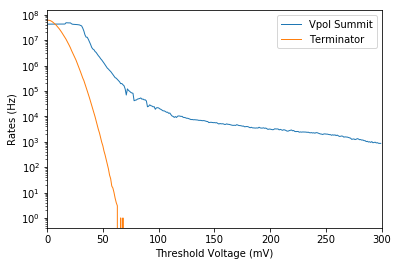

In [151]:
plotThresholdScan(measRatesHead, measRates,label='Vpol Summit')
plotThresholdScan(termRatesHead, termRates, label='Terminator')
#pyp.ylim(0.1,10)
#pyp.xlim(50,75)
pyp.legend()
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

#### 11: Rates run in Vpol with rates from photon counter, spectra from SA, and waveforms from scope.


Trigger level on scope was 0 mV (should be checked in the data header), so unbiased. Chose threshold for photon counter of 63 mV that corresponds to the threhsold at which the terminator gave 1 Hz rates. 

Saw a persistent spike at 53 MHz and the 42 MHz line from airplanes was coming and going.

Towards the end of the run, SAW accidentally turned the power supply to the amps off and back on. Disregard the data after that.

In [153]:
run = 11
measSpecHead, measSpecRunHead, measSpectra, measRatesHead, measRates, measWaves = getData(
    run, 20180915, [ 'tekScope', 'specanalyzer','photonCounter'])

Scope File Name  /home/radio/data/beacon_september2018//20180915/20180915/tekScope_run11_20180915_13-13-21-287741.csv
/home/radio/data/beacon_september2018//20180915/specanalyzer_run11_*.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_september2018//20180915/specanalyzer_run11_2018-09-15_13-13-16.hdf5
Photon Counter File Name /home/radio/data/beacon_september2018//20180915/photonCounter_run11_2018-09-15_13-13-12.hdf5


In [154]:
for key in measRatesHead.keys():
    print(key, ":", measRatesHead[key].values[0])

run : 11
timestamp : 1537042392.20238
filename : photonCounter_run11_2018-09-15_13-13-12.hdf5
freqband : VHF
pol : V
weather : Cold and windy
daynight : Day
comments : Running at 63 mV because that's the threshold where the terminator is at 1 Hz. Seeing a persistent spike at 53 MHz
boxno : 1
before_stage1_attenfilter : NLP90,NLP100
after_stage2_attenfilter : NLP90
fixedDiscThresholdmV : 63.0
discAMode : 0
runTimeMinutes : 10.0
countPeriodSeconds : 1.0
NPeriods : 600
countMode : 0
counterAInput : 1
counterTInput : 0


In [155]:
for key in measSpecRunHead.keys():
    print(key, ":", measSpecRunHead[key].values[0])

run : 11
timestamp : 1537042396.4852731
filename : specanalyzer_run11_2018-09-15_13-13-16.hdf5
freqband : VHF
pol : V
weather : Cold and windy
daynight : Day
comments : Running at 63 mV because that's the threshold where the terminator is at 1 Hz. Seeing a persistent spike at 53 MHz
boxno : 1
before_stage1_attenfilter : NLP90,NLP100
after_stage2_attenfilter : NLP90


In [156]:
for key in measSpecHead.keys():
        print(key, ":", measSpecHead[key])

2018-09-15-06-13-20-29 : ACPR_ADJC_CH_BW                        10.350000 MHZ
ACPR_CHANNEL_SPACING                   10.350000 MHZ
ACPR_LOWER_CH_LINE_MARKER_INFO              0.000000
ACPR_LOWER_CH_PWR                       10.000000 DB
ACPR_MAIN_CH_BW                        10.350000 MHZ
ACPR_MAIN_CH_LINE_MARKER_INFO               0.000000
ACPR_MAIN_CH_PWR                       10.000000 DBM
ACPR_UPPER_CH_LINE_MARKER_INFO              0.000000
ACPR_UPPER_CH_PWR                       10.000000 DB
ACTIVE_MEASUREMENT                          0.000000
AM_FM_DEMOD_FREQUENCY                  10.350000 MHZ
AM_FM_DEMOD_TIME                          3.000000 S
AM_FM_DEMOD_TYPE                            1.000000
AM_FM_DEMOD_VOL                             0.000000
AM_FM_LINE_MARKER                           0.000000
ANTENNA                                     0.000000
APP_MODE                                            
APP_NAME                                         SPA
APP_VER              

Name: 2018-09-15-06-13-23-48, Length: 195, dtype: object
2018-09-15-06-13-24-01 : ACPR_ADJC_CH_BW                        10.350000 MHZ
ACPR_CHANNEL_SPACING                   10.350000 MHZ
ACPR_LOWER_CH_LINE_MARKER_INFO              0.000000
ACPR_LOWER_CH_PWR                       10.000000 DB
ACPR_MAIN_CH_BW                        10.350000 MHZ
ACPR_MAIN_CH_LINE_MARKER_INFO               0.000000
ACPR_MAIN_CH_PWR                       10.000000 DBM
ACPR_UPPER_CH_LINE_MARKER_INFO              0.000000
ACPR_UPPER_CH_PWR                       10.000000 DB
ACTIVE_MEASUREMENT                          0.000000
AM_FM_DEMOD_FREQUENCY                  10.350000 MHZ
AM_FM_DEMOD_TIME                          3.000000 S
AM_FM_DEMOD_TYPE                            1.000000
AM_FM_DEMOD_VOL                             0.000000
AM_FM_LINE_MARKER                           0.000000
ANTENNA                                     0.000000
APP_MODE                                            
APP_NAME         

<IPython.core.display.Javascript object>


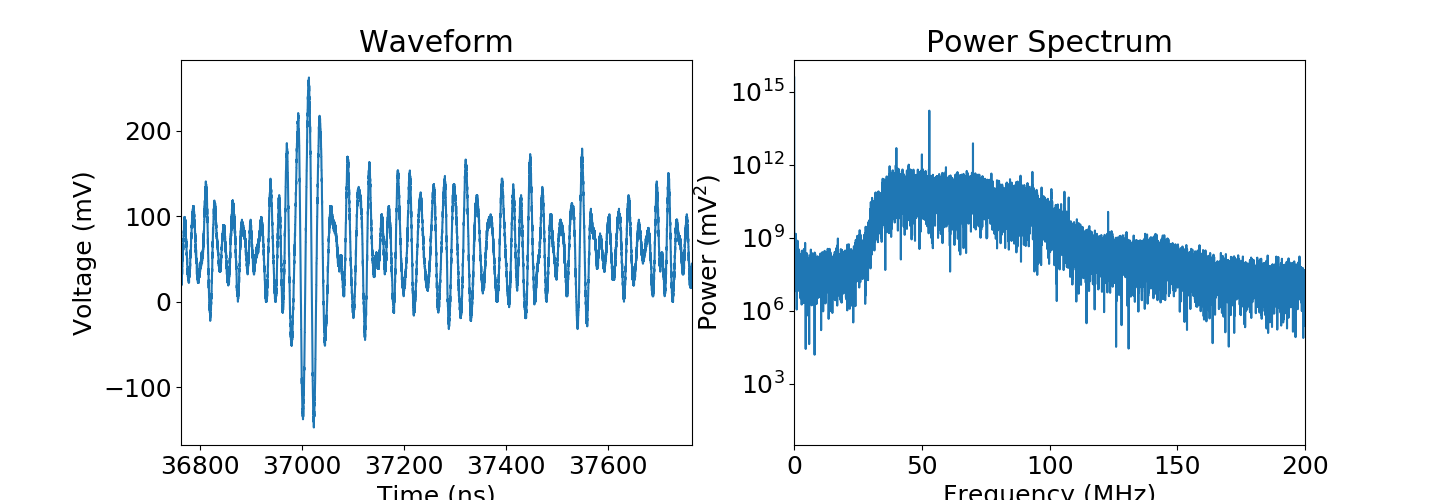

In [157]:
%matplotlib notebook
fig,ax = pyp.subplots(1,2,figsize=(14.5,5))
for eid in measWaves.keys():
    if( eid > 1):
        ax[0].clear()
        ax[1].clear()
    chan = 0
    draw_channel_ax(ax,measWaves,eid,chan)
    #pyp.subplot(1,2,1)
    zoom_wave_ax(ax,measWaves,eid,chan, 1000)
    #ax.subplot(1,2,2)
    ax[1].set_xlim(0,200)
    #yp.show()
    fig.canvas.draw()
    #
    #display.display(pl.gcf())
    #display.clear_output(wait=True)
    time.sleep(1)
    

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


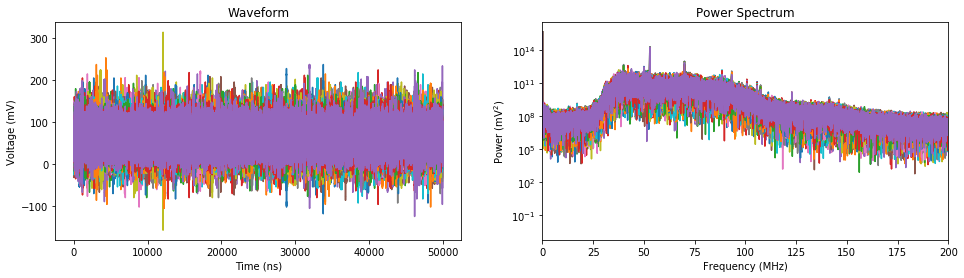

In [158]:
%matplotlib inline 
therm_ind = range(45)
#print(measWaves)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)
pyp.subplot(1,2,2)
pyp.xlim(0,200)

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


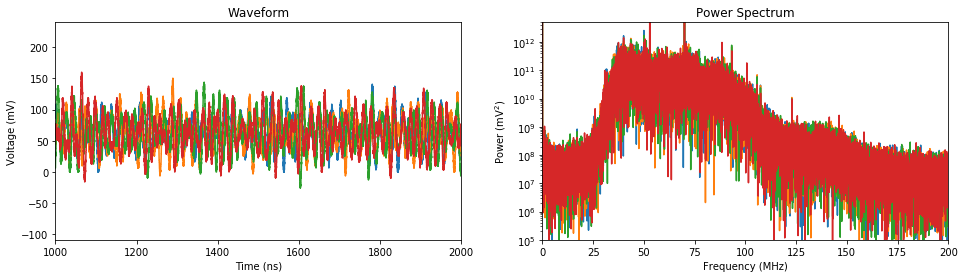

In [159]:
# change the indices to select different waveforms
wave_ind = [0,12,73,80]
for eid in measWaves.keys()[wave_ind]:
        draw_channel(measWaves, eid,0)
pyp.subplot(1,2,1)
pyp.xlim(1000,2000)
pyp.subplot(1,2,2)
pyp.xlim(0,200)
pyp.ylim(1e5,5e12)

fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

In [ ]:
plotSpectrogram(measSpecHead, measSpectra)
pyp.subplot(2,1,1)
pyp.ylim(0,515)
pyp.subplot(2,1,2)
pyp.ylim(0,515)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [ ]:
plotRatesTime(measRatesHead,measRates)
pyp.xlim(2400+1.53704e9, 2900+1.53704e9)
fignum = fignum + 1
pyp.savefig("%s/20180915_run%d_fig%d.pdf"%(outDirc,run,fignum))